# PacMan - Reinforcement Learning

*Course: Machine Learning Projects with TensorFlow 2.0 by Vlad Sebastian Ionescu*

In [1]:
import gym
from IPython import display
from IPython.display import clear_output
import time
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Sample Environment - Taxi

In [2]:
env = gym.make('Taxi-v3')
env.reset()

164

In [3]:
env.P #{state: {action: [(probability, next_state, reward, done)]}}

{0: {0: [(1.0, 100, -1, False)],
  1: [(1.0, 0, -1, False)],
  2: [(1.0, 20, -1, False)],
  3: [(1.0, 0, -1, False)],
  4: [(1.0, 16, -1, False)],
  5: [(1.0, 0, -10, False)]},
 1: {0: [(1.0, 101, -1, False)],
  1: [(1.0, 1, -1, False)],
  2: [(1.0, 21, -1, False)],
  3: [(1.0, 1, -1, False)],
  4: [(1.0, 17, -1, False)],
  5: [(1.0, 1, -10, False)]},
 2: {0: [(1.0, 102, -1, False)],
  1: [(1.0, 2, -1, False)],
  2: [(1.0, 22, -1, False)],
  3: [(1.0, 2, -1, False)],
  4: [(1.0, 18, -1, False)],
  5: [(1.0, 2, -10, False)]},
 3: {0: [(1.0, 103, -1, False)],
  1: [(1.0, 3, -1, False)],
  2: [(1.0, 23, -1, False)],
  3: [(1.0, 3, -1, False)],
  4: [(1.0, 19, -1, False)],
  5: [(1.0, 3, -10, False)]},
 4: {0: [(1.0, 104, -1, False)],
  1: [(1.0, 4, -1, False)],
  2: [(1.0, 24, -1, False)],
  3: [(1.0, 4, -1, False)],
  4: [(1.0, 4, -10, False)],
  5: [(1.0, 4, -10, False)]},
 5: {0: [(1.0, 105, -1, False)],
  1: [(1.0, 5, -1, False)],
  2: [(1.0, 25, -1, False)],
  3: [(1.0, 5, -1, False)

In [4]:
for step in range(100):
    action = env.action_space.sample()
    new_state, reward, done, info = env.step(action)
    
    clear_output(wait=True)
    print(env.render(mode='ansi'))
    print(f'Timestep: {step+1}')
    print(f'State: {new_state}')
    print(f'Action: {action}')
    print(f'Reward: {reward}')
    time.sleep(0.1)

+---------+
|R: | : :G|
| : | : : |
| : : : :_|
| | : | : |
|Y| : |B: |
+---------+
  (East)

Timestep: 100
State: 296
Action: 2
Reward: -1


## 2. PacMan Environment

In [5]:
env = gym.make('MsPacman-v0')
_ = env.reset()

In [6]:
print('Observation Spec:')
print(env.observation_space)

print('Reward Spec:')
print(env.reward_range)

print('Action Spec:')
print(env.action_space)

Observation Spec:
Box(210, 160, 3)
Reward Spec:
(-inf, inf)
Action Spec:
Discrete(9)


KeyboardInterrupt: 

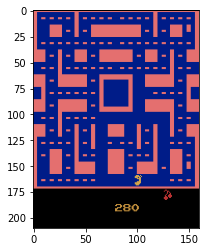

In [7]:
img = plt.imshow(env.render(mode='rgb_array'))
for _ in range(5000):
    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action = env.action_space.sample()
    env.step(action)

### 2.1 TF Agents

#### Environment preprocessing

In [8]:
import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.networks import q_network
from tf_agents.environments import suite_gym, tf_py_environment
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.policies import random_tf_policy
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

In [9]:
train_py_env = suite_gym.load('MsPacman-v0')
eval_py_env = suite_gym.load('MsPacman-v0')

# Wrap them as TF environments
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

#### Agent Setup

In [10]:
# Parameters for fully connected hidden layers (1 hidden layer of size 100)
fc_layer_params = (100, )

q_net = q_network.QNetwork(train_env.observation_spec(),
                           train_env.action_spec(),
                           fc_layer_params=fc_layer_params)

In [11]:
optimizer = tf.compat.v1.train.AdamOptimizer()

train_step_counter = tf.Variable(0)

# Define the agent. DqnAgent is a general purpose algorithm 

agent = dqn_agent.DqnAgent(train_env.time_step_spec(),
                           train_env.action_spec(),
                           q_network=q_net,
                           optimizer=optimizer,
                           td_errors_loss_fn=common.element_wise_squared_loss,
                           train_step_counter=train_step_counter)
agent.initialize()

In [12]:
eval_policy = agent.policy
collect_policy = agent.collect_policy
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(), 
                                                train_env.action_spec())
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(data_spec=agent.collect_data_spec,
                                                               batch_size=train_env.batch_size,
                                                               max_length=10000)

In [13]:
def compute_avg_return(environment, policy, num_episodes=10):
    total_return = 0.0
    for _ in range(num_episodes):
        
        time_step = environment.reset()
        episode_return = 0.0
        
        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        
        total_return += episode_return
        
    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    # Traj is a move for a given time_step by an action to the next_time_step
    traj = trajectory.from_transition(time_step, action_step, next_time_step)
    
    buffer.add_batch(traj)
    
def collect_data(env, policy, buffer, steps):
    for _ in range(steps):
        collect_step(env, policy, buffer)
        
collect_data(train_env, random_policy, replay_buffer, steps=100)

In [14]:
dataset = replay_buffer.as_dataset(num_parallel_calls=3,
                                   sample_batch_size=64,
                                   num_steps=2).prefetch(3)
iterator = iter(dataset)

#### Agent Training

In [17]:
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter(0)

# Evaluate agent's plociy before training
avg_return = compute_avg_return(eval_env, agent.policy, 10)
returns = [avg_return]

for _ in range(1000):
    
    for _ in range(100):
        # Collect a few steps using collect_policy and saving them to replay_buffer
        collect_step(train_env, agent.collect_policy, replay_buffer)
        
        # Sample batch of data from the buffer and update agent's network
        experience, unused_info = next(iterater)
        train_loss = agent.train(experience).loss
        
        step = agent.train_step_counter.numpy()
        
        if step % 100 == 0:
            print(f'step={step}: loss={train_loss}')
        if step % 200 == 0:
            avg_return = compute_avg_return(eval_env, agent.policy, 10)
            print(f'step={step}: Average Return={avg_return}')
            returns.append(avg_return)
        

TypeError: 'ResourceVariable' object is not callable